<a href="https://colab.research.google.com/github/Zfeng0207/FIT3199-FYP/blob/dev%2Fzfeng/lstm_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main')

TPU has a different way of downloading dependencies keep the cell below to avoid dependency conflicts

In [3]:
!pip install --user -qqqq mlflow wfdb resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.

In [4]:
import sys
import os

user_lib_path = os.path.expanduser("~/.local/lib/python3.11/site-packages")
if user_lib_path not in sys.path:
    sys.path.append(user_lib_path)

In [5]:
import mlflow
import wfdb
import resampy

In [6]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main/src')

import argparse
import pandas as pd
import numpy as np
from pathlib import Path
import wfdb
from tqdm.auto import tqdm
from extract_headers import extract_and_open_files_in_zip
from ecg_utils import prepare_mimicecg
from mimic_ecg_preprocessing import prepare_mimic_ecg

In [7]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main/src/utils')

# from timeseries_utils import reformat_as_memmap
from stratify import stratified_subsets

In [8]:
memmap_meta_path = "src/data/memmap_meta.npz"
memmap_path = "src/data/memmap/memmap.npy"
df_mapped_path = "src/data/records_w_stroke_labels.csv"
df_pkl_path = "src/data/processed/df.pkl"

# Merge dataset with labels and ecg paths

In [9]:
df_pkl = pd.read_pickle(df_pkl_path)
df_mapped = pd.read_csv(df_mapped_path)  # Assuming df_mapped is saved as a pickle

merged_df = pd.merge(df_pkl, df_mapped, on=["study_id"], how="left")


# Labeling stroke classes

In [10]:
# Transform the 'label_strat_all2all' column
merged_df['Stroke_YN'] = merged_df['label_strat_all2all'].apply(lambda x: 0 if x == "['outpatient']" else 1)

# Verify the transformation
print(merged_df[['label_strat_all2all', 'Stroke_YN']].head())

  label_strat_all2all  Stroke_YN
0      ['outpatient']          0
1      ['outpatient']          0
2      ['outpatient']          0
3      ['outpatient']          0
4      ['outpatient']          0


# Visualizing target class distribution

<ipython-input-11-86ee3fd71fa9>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")


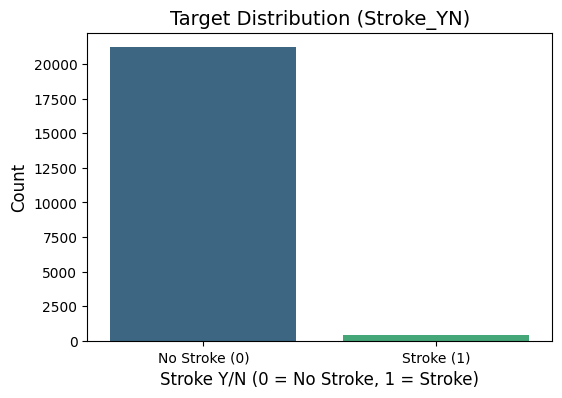

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each target class
target_counts = merged_df['Stroke_YN'].value_counts()

# Plot the distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")
plt.title("Target Distribution (Stroke_YN)", fontsize=14)
plt.xlabel("Stroke Y/N (0 = No Stroke, 1 = Stroke)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], labels=["No Stroke (0)", "Stroke (1)"])
plt.show()

In [12]:
# merged_df.to_csv("/Users/zfeng/Documents/ECG-MIMIC/ECG-MIMIC/preprocessed_data/merged_df.csv", index=False)

# Setting up Mlflow for model baseline tracking

In [13]:
import mlflow
import mlflow.pytorch
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import os

os.environ['MLFLOW_TRACKING_USERNAME'] = "Zfeng0207"
os.environ['MLFLOW_TRACKING_PASSWORD'] = "af7c8365aec4d3ff7a40563a35ec94d4bc9b4512"
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = "stroke-prediction-dagshub-repo"

experiment_name = "ecg-lstm-experiment"
mlflow.set_tracking_uri(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME'] + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')
mlflow.set_experiment(experiment_name)

print(f"MLflow tracking experiment name: {experiment_name}")
print(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME'] + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')


MLflow tracking experiment name: ecg-lstm-experiment
https://dagshub.com/Zfeng0207/stroke-prediction-dagshub-repo.mlflow


# Data Class

In [40]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class ECGDataset(Dataset):
    def __init__(self, indices, ecg_memmap, starts, lengths, labels):
        self.indices = indices
        self.ecg_memmap = ecg_memmap
        self.starts = starts
        self.lengths = lengths
        self.labels = labels

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        true_idx = self.indices[idx]
        start = self.starts[true_idx]
        length = self.lengths[true_idx]
        ecg = self.ecg_memmap[start:start+length]
        # Reshape the ECG data to have 12 features
        ecg = ecg.reshape(-1, 12)  # Assuming your ECG data can be reshaped to (-1, 12)
        ecg_tensor = torch.tensor(ecg, dtype=torch.float32)
        label = torch.tensor(self.labels[true_idx], dtype=torch.long)
        return ecg_tensor, label

# Simple LSTM Model

In [15]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])  # Use the last hidden state
        return out  # No sigmoid here

In [16]:
def collate_fn(batch):
    ecgs, labels = zip(*batch)
    ecgs_padded = pad_sequence(ecgs, batch_first=True)  # shape: (B, T_max)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    lengths = torch.tensor([len(e) for e in ecgs], dtype=torch.long)
    return ecgs_padded, labels_tensor, lengths

In [17]:
from tqdm.auto import tqdm

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    device = torch.device("cuda")

    with torch.no_grad():
        for ecg_signals, labels in tqdm(dataloader, desc="Evaluating", leave=False):
          if torch.cuda.is_available():
            ecg_signals = ecg_signals.to(device)
            labels = labels.to(device)
          outputs = model(ecg_signals)
          probs = torch.sigmoid(outputs).squeeze(1)
          preds = (probs >= 0.5).int()
          all_preds.extend(preds.tolist())
          all_labels.extend(labels.squeeze().tolist())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float("nan")  # AUC requires both classes to be present

    return acc, f1, auc


# Model Training

In [38]:
import mlflow
import mlflow.pytorch
from sklearn.utils.class_weight import compute_class_weight

def train_model(train_df, val_df, ecg_memmap, metadata, labels, num_epochs=10, BATCH_SIZE = 32):
    indices = np.arange(len(labels))

    ecg_memmap = np.fromfile(ecg_memmap, dtype=np.float32)
    metadata = np.load(metadata)
    starts = metadata['start']
    lengths = metadata['length']

    train_dataset = ECGDataset(train_idx, ecg_memmap, starts, lengths, labels)
    val_dataset = ECGDataset(val_idx, ecg_memmap, starts, lengths, labels)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    hidden_size = 64
    num_layers = 2
    batch_size = 32
    lr = 0.001

    # device = torch.device("cuda")

    model = SimpleLSTM(input_size=12, hidden_size=hidden_size, num_layers=num_layers, output_size=1)
    # model = model.to(device)

    class_labels = np.unique(labels)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=labels)
    class_weights_dict = dict(zip(class_labels, class_weights))

    pos_weight = class_weights_dict[1]

    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight, dtype=torch.float32))

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    with mlflow.start_run():
        # Log hyperparameters
        mlflow.log_param("hidden_size", hidden_size)
        mlflow.log_param("num_layers", num_layers)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", lr)
        mlflow.log_param("epochs", num_epochs)

        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0.0
            for ecg_signals, labels, lengths in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False): # Modified line to unpack lengths
                # if torch.cuda.is_available():
                #   ecg_signals = ecg_signals.to(device)
                #   labels = labels.to(device)

                outputs = model(ecg_signals)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                epoch_loss += loss.item()

            val_acc, val_f1, val_auc = evaluate_model(model, val_loader)

            # Log metrics for each epoch
            mlflow.log_metric("train_loss", epoch_loss / len(train_loader), step=epoch)
            mlflow.log_metric("val_accuracy", val_acc, step=epoch)
            mlflow.log_metric("val_f1", val_f1, step=epoch)
            mlflow.log_metric("val_auc", val_auc, step=epoch)

            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}, "
                  f"Val Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

        # Save model artifact
        model_path = "src/model/simple_lstm_model.pth" #parent doesnt exist
        # torch.save(model.state_dict(), model_path)
        # mlflow.log_artifact(model_path)
        # mlflow.pytorch.log_model(model, artifact_path="lstm_model")

        print("✅ Model tracked with MLflow")

    return model

In [19]:
def test_model(model, test_df, memmap_file, memmap_meta_file):
    test_dataset = ECGDataset(test_df, memmap_file, memmap_meta_file)
    test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

    acc, f1, auc = evaluate_model(model, test_loader)
    print(f"\n📊 Test Results — Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {auc:.4f}")

    # Optionally log test metrics
    mlflow.log_metric("test_accuracy", acc)
    mlflow.log_metric("test_f1", f1)
    mlflow.log_metric("test_auc", auc)


In [41]:
from sklearn.model_selection import train_test_split

labels = merged_df['Stroke_YN'].values
indices = np.arange(len(labels))

train_idx, temp_idx, train_y, temp_y = train_test_split(
    indices, labels, test_size=0.2, stratify=labels, random_state=42
)

val_idx, test_idx, val_y, test_y = train_test_split(
    temp_idx, temp_y, test_size=0.5, stratify=temp_y, random_state=42
)

# Train and test
model = train_model(train_idx, val_idx, memmap_path, memmap_meta_path, labels, num_epochs=10)
test_model(model, test_idx, memmap_path, memmap_meta_path)

Epoch 1/10:   0%|          | 0/542 [00:00<?, ?it/s]

🏃 View run whimsical-toad-422 at: https://dagshub.com/Zfeng0207/stroke-prediction-dagshub-repo.mlflow/#/experiments/0/runs/a2996aff8d70484d9b413dd5bdf43ed5
🧪 View experiment at: https://dagshub.com/Zfeng0207/stroke-prediction-dagshub-repo.mlflow/#/experiments/0


ValueError: cannot reshape array of size 1000 into shape (12)